In [40]:
# Plots for assembly accuracy with lossy compression

In [41]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import csv
import pandas as pd

In [42]:
compressed_size_dir = '../../data/Klebsiella_pneumoniae_INF032/compressed_size_summary/'
NUM_EXP = 10 # we tried maxerror parameter from 1 to 10

In [43]:
# load compressed sizes and signal lengths into numpy arrays
# array size = number of reads

with open(compressed_size_dir+'/VBZ_lossless.tsv') as tsvfile:
    reader = csv.reader(tsvfile, delimiter='\t')
    rows = [row for row in reader]
    
signal_lengths = np.array([int(row[1]) for row in rows[1:]],dtype=int)
lossless_sizes = np.array([int(row[2]) for row in rows[1:]],dtype=int)

LFZip_sizes = np.zeros((NUM_EXP,len(lossless_sizes)),dtype=int)
SZ_sizes = np.zeros((NUM_EXP,len(lossless_sizes)),dtype=int)

for i in range(NUM_EXP):
    with open(compressed_size_dir+'/LFZip_maxerror_'+str(i+1)+'.tsv') as tsvfile:
        reader = csv.reader(tsvfile, delimiter='\t')
        rows = [row for row in reader]
    LFZip_sizes[i,:] = np.array([int(row[2]) for row in rows[1:]],dtype=int)
    
for i in range(NUM_EXP):
    with open(compressed_size_dir+'/SZ_maxerror_'+str(i+1)+'.tsv') as tsvfile:
        reader = csv.reader(tsvfile, delimiter='\t')
        rows = [row for row in reader]
    SZ_sizes[i,:] = np.array([int(row[2]) for row in rows[1:]],dtype=int)
    

In [44]:
# compute some totals 
signal_lengths_sum = np.sum(signal_lengths)
lossless_sizes_sum = np.sum(lossless_sizes)
LFZip_sizes_sum = np.sum(LFZip_sizes,axis=1)
SZ_sizes_sum = np.sum(SZ_sizes,axis=1)

In [45]:
# Average compression ratio (bytes/signal value) for lossless compression
print('Lossless compression ratio:','{:.3f}'.format((lossless_sizes_sum/signal_lengths_sum)))

Lossless compression ratio: 0.852


In [46]:
# Now load the assembly data
data_dir = '../../data/Klebsiella_pneumoniae_INF032/'

basecallers = ['guppy_hac','guppy_fast','guppy_mod','bonito']
assemblers = ['flye','rebaler','medaka']
assembly_identity = {basecaller: [{'lossless':{},'LFZip':{},'SZ':{}} for _ in range(4)] for basecaller in basecallers}
# 4 subsampling experiments

for basecaller in basecallers:
    for j,subsampling_suffix in enumerate(["summary","subsampled_2_summary","subsampled_4_summary","subsampled_8_summary"]):
        assembly_summary_file = data_dir+"/"+basecaller+"/assembly_"+subsampling_suffix+".tsv"
        # read file
        with open(assembly_summary_file) as tsvfile:
            reader = csv.reader(tsvfile, delimiter='\t')
            rows = [row for row in reader]

        data_dict = {}
        for row in rows[1:]:
            data_dict[row[0]] = row[1:]
        for assembler in assemblers:
            assembly_identity[basecaller][j]['lossless'][assembler] = float(data_dict['lossless_'+assembler][2].rstrip('%'))

        for compressor in ['LFZip','SZ']:
            for assembler in assemblers:
                assembly_identity[basecaller][j][compressor][assembler] =\
                    np.array([float(data_dict[compressor+'_maxerror_'+str(i+1)+'_'+assembler][2].rstrip('%')) \
                                for i in range(NUM_EXP)])

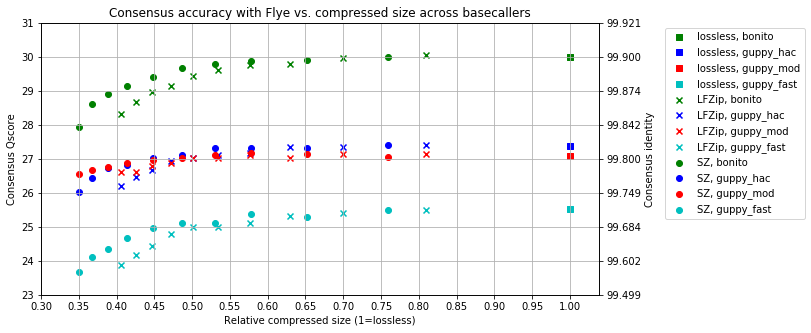

In [48]:
# flye assembly across basecallers

basecallers = ['bonito','guppy_hac','guppy_mod','guppy_fast']
color = {'guppy_hac': 'b', 'guppy_mod': 'r','guppy_fast': 'c','bonito':'g'}
marker = {'LFZip': 'x', 'SZ': 'o'}
compressed_sizes = {'LFZip': LFZip_sizes_sum/lossless_sizes_sum, 'SZ': SZ_sizes_sum/lossless_sizes_sum}
legend = []

def phred(x):
    return -10*np.log10((100-x)/100)
    
_,ax_phred = plt.subplots(figsize=(10,5))
ax_percent = ax_phred.twinx()

assembler = 'flye'
sidx = 0 # no subsampling

# scatter plots
for basecaller in basecallers:
    ax_phred.scatter(1.0,phred(assembly_identity[basecaller][sidx]['lossless'][assembler]),marker='s',color=color[basecaller])
    legend.append('lossless, '+basecaller)
for compressor in ['LFZip','SZ']:
    for basecaller in basecallers:
        ax_phred.scatter(compressed_sizes[compressor],\
                    phred(assembly_identity[basecaller][sidx][compressor][assembler]),\
                    color=color[basecaller], marker=marker[compressor])
        legend.append(compressor+', '+basecaller)
ax_phred.legend(legend,bbox_to_anchor=(1.11,1), loc="upper left")
yticks = list(range(23,32))
ax_phred.set_yticks(yticks)
percent_ticks = 100-100*np.power(10,-np.array(yticks)/10)
percent_ticks_str = ['{:.3f}'.format(val) for val in percent_ticks]
ax_percent.set_ylim(ax_phred.get_ylim())
ax_percent.set_yticks(ax_phred.get_yticks())
ax_percent.set_yticklabels(percent_ticks_str)
ax_phred.set_xticks(np.arange(0.3,1.05,0.05))
ax_phred.set_xlabel('Relative compressed size (1=lossless)')
ax_phred.set_ylabel('Consensus Qscore')
ax_phred.set_title('Consensus accuracy with Flye vs. compressed size across basecallers')
ax_percent.set_ylabel('Consensus identity')
ax_phred.grid()
plt.savefig('assembly_flye_basecallers.pdf',bbox_inches='tight')

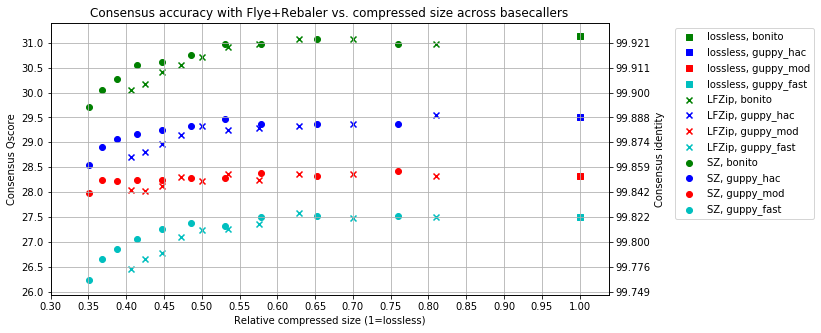

In [51]:
# rebaler assembly across basecallers

basecallers = ['bonito','guppy_hac','guppy_mod','guppy_fast']
color = {'guppy_hac': 'b', 'guppy_mod': 'r','guppy_fast': 'c','bonito':'g'}
marker = {'LFZip': 'x', 'SZ': 'o'}
compressed_sizes = {'LFZip': LFZip_sizes_sum/lossless_sizes_sum, 'SZ': SZ_sizes_sum/lossless_sizes_sum}
legend = []

def phred(x):
    return -10*np.log10((100-x)/100)
    
_,ax_phred = plt.subplots(figsize=(10,5))
ax_percent = ax_phred.twinx()

assembler = 'rebaler'
sidx = 0 # no subsampling

# scatter plots
for basecaller in basecallers:
    ax_phred.scatter(1.0,phred(assembly_identity[basecaller][sidx]['lossless'][assembler]),marker='s',color=color[basecaller])
    legend.append('lossless, '+basecaller)
for compressor in ['LFZip','SZ']:
    for basecaller in basecallers:
        ax_phred.scatter(compressed_sizes[compressor],\
                    phred(assembly_identity[basecaller][sidx][compressor][assembler]),\
                    color=color[basecaller], marker=marker[compressor])
        legend.append(compressor+', '+basecaller)
ax_phred.legend(legend,bbox_to_anchor=(1.11,1), loc="upper left")
yticks = list(np.arange(26,31.5,0.5))
ax_phred.set_yticks(yticks)
percent_ticks = 100-100*np.power(10,-np.array(yticks)/10)
percent_ticks_str = ['{:.3f}'.format(val) for val in percent_ticks]
ax_percent.set_ylim(ax_phred.get_ylim())
ax_percent.set_yticks(ax_phred.get_yticks())
ax_percent.set_yticklabels(percent_ticks_str)
ax_phred.set_xticks(np.arange(0.3,1.05,0.05))
ax_phred.set_xlabel('Relative compressed size (1=lossless)')
ax_phred.set_ylabel('Consensus Qscore')
ax_phred.set_title('Consensus accuracy with Flye+Rebaler vs. compressed size across basecallers')
ax_percent.set_ylabel('Consensus identity')
ax_phred.grid()
plt.savefig('assembly_rebaler_basecallers.pdf',bbox_inches='tight')

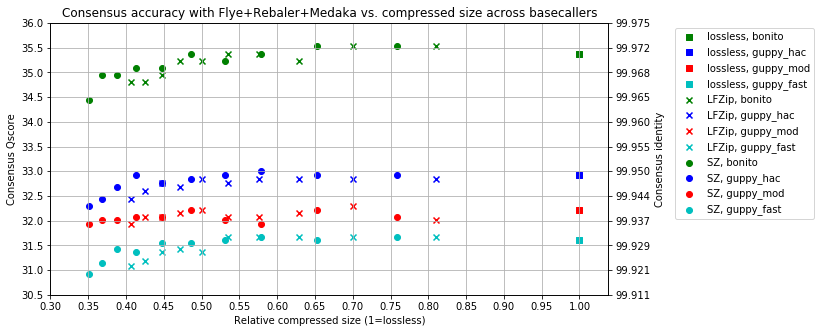

In [54]:
# medaka assembly across basecallers

basecallers = ['bonito','guppy_hac','guppy_mod','guppy_fast']
color = {'guppy_hac': 'b', 'guppy_mod': 'r','guppy_fast': 'c','bonito':'g'}
marker = {'LFZip': 'x', 'SZ': 'o'}
compressed_sizes = {'LFZip': LFZip_sizes_sum/lossless_sizes_sum, 'SZ': SZ_sizes_sum/lossless_sizes_sum}
legend = []

def phred(x):
    return -10*np.log10((100-x)/100)
    
_,ax_phred = plt.subplots(figsize=(10,5))
ax_percent = ax_phred.twinx()

assembler = 'medaka'
sidx = 0 # no subsampling

# scatter plots
for basecaller in basecallers:
    ax_phred.scatter(1.0,phred(assembly_identity[basecaller][sidx]['lossless'][assembler]),marker='s',color=color[basecaller])
    legend.append('lossless, '+basecaller)
for compressor in ['LFZip','SZ']:
    for basecaller in basecallers:
        ax_phred.scatter(compressed_sizes[compressor],\
                    phred(assembly_identity[basecaller][sidx][compressor][assembler]),\
                    color=color[basecaller], marker=marker[compressor])
        legend.append(compressor+', '+basecaller)
ax_phred.legend(legend,bbox_to_anchor=(1.11,1), loc="upper left")
yticks = list(np.arange(30.5,36.5,0.5))
ax_phred.set_yticks(yticks)
percent_ticks = 100-100*np.power(10,-np.array(yticks)/10)
percent_ticks_str = ['{:.3f}'.format(val) for val in percent_ticks]
ax_percent.set_ylim(ax_phred.get_ylim())
ax_percent.set_yticks(ax_phred.get_yticks())
ax_percent.set_yticklabels(percent_ticks_str)
ax_phred.set_xticks(np.arange(0.3,1.05,0.05))
ax_phred.set_xlabel('Relative compressed size (1=lossless)')
ax_phred.set_ylabel('Consensus Qscore')
ax_phred.set_title('Consensus accuracy with Flye+Rebaler+Medaka vs. compressed size across basecallers')
ax_percent.set_ylabel('Consensus identity')
ax_phred.grid()
plt.savefig('assembly_medaka_basecallers.pdf',bbox_inches='tight')

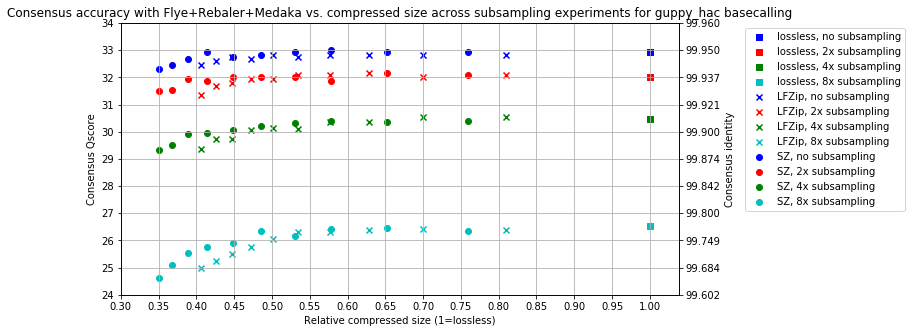

In [55]:
# medaka assembly across subsampling (guppy_hac)
marker = {'LFZip': 'x', 'SZ': 'o'}
compressed_sizes = {'LFZip': LFZip_sizes_sum/lossless_sizes_sum, 'SZ': SZ_sizes_sum/lossless_sizes_sum}
legend = []

def phred(x):
    return -10*np.log10((100-x)/100)
    
_,ax_phred = plt.subplots(figsize=(10,5))
ax_percent = ax_phred.twinx()

assembler = 'medaka'
basecaller = 'guppy_hac'
subsampling_legend = ['no subsampling','2x subsampling','4x subsampling', '8x subsampling']
color = ['b','r','g','c']

# scatter plots
for sidx in range(4):
    ax_phred.scatter(1.0,phred(assembly_identity[basecaller][sidx]['lossless'][assembler]),marker='s',color=color[sidx])
    legend.append('lossless, '+subsampling_legend[sidx])
for compressor in ['LFZip','SZ']:
    for sidx in range(4):
        ax_phred.scatter(compressed_sizes[compressor],\
                    phred(assembly_identity[basecaller][sidx][compressor][assembler]),\
                    color=color[sidx], marker=marker[compressor])
        legend.append(compressor+', '+subsampling_legend[sidx])
ax_phred.legend(legend,bbox_to_anchor=(1.11,1), loc="upper left")
yticks = list(range(24,35))
ax_phred.set_yticks(yticks)
percent_ticks = 100-100*np.power(10,-np.array(yticks)/10)
percent_ticks_str = ['{:.3f}'.format(val) for val in percent_ticks]
ax_percent.set_ylim(ax_phred.get_ylim())
ax_percent.set_yticks(ax_phred.get_yticks())
ax_percent.set_yticklabels(percent_ticks_str)
ax_phred.set_xticks(np.arange(0.3,1.05,0.05))
ax_phred.set_xlabel('Relative compressed size (1=lossless)')
ax_phred.set_ylabel('Consensus Qscore')
ax_phred.set_title('Consensus accuracy with Flye+Rebaler+Medaka vs. compressed size across subsampling experiments for guppy_hac basecalling')
ax_percent.set_ylabel('Consensus identity')
ax_phred.grid()
plt.savefig('assembly_subsampling_medaka_guppy_hac.pdf',bbox_inches='tight')

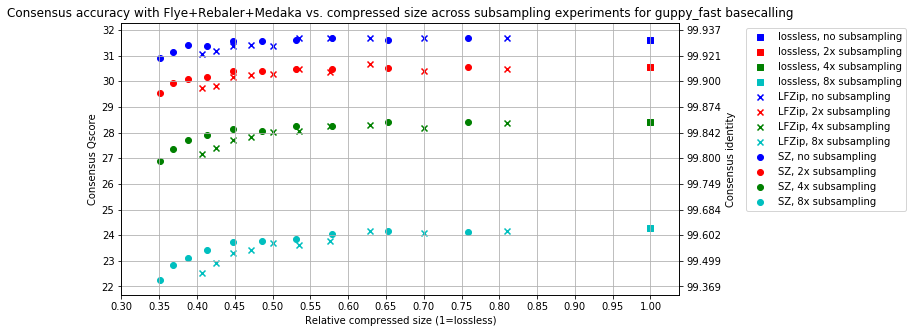

In [56]:
# medaka assembly across subsampling (guppy_fast)
marker = {'LFZip': 'x', 'SZ': 'o'}
compressed_sizes = {'LFZip': LFZip_sizes_sum/lossless_sizes_sum, 'SZ': SZ_sizes_sum/lossless_sizes_sum}
legend = []

def phred(x):
    return -10*np.log10((100-x)/100)
    
_,ax_phred = plt.subplots(figsize=(10,5))
ax_percent = ax_phred.twinx()

assembler = 'medaka'
basecaller = 'guppy_fast'
subsampling_legend = ['no subsampling','2x subsampling','4x subsampling', '8x subsampling']
color = ['b','r','g','c']

# scatter plots
for sidx in range(4):
    ax_phred.scatter(1.0,phred(assembly_identity[basecaller][sidx]['lossless'][assembler]),marker='s',color=color[sidx])
    legend.append('lossless, '+subsampling_legend[sidx])
for compressor in ['LFZip','SZ']:
    for sidx in range(4):
        ax_phred.scatter(compressed_sizes[compressor],\
                    phred(assembly_identity[basecaller][sidx][compressor][assembler]),\
                    color=color[sidx], marker=marker[compressor])
        legend.append(compressor+', '+subsampling_legend[sidx])
ax_phred.legend(legend,bbox_to_anchor=(1.11,1), loc="upper left")
yticks = list(range(22,33))
ax_phred.set_yticks(yticks)
percent_ticks = 100-100*np.power(10,-np.array(yticks)/10)
percent_ticks_str = ['{:.3f}'.format(val) for val in percent_ticks]
ax_percent.set_ylim(ax_phred.get_ylim())
ax_percent.set_yticks(ax_phred.get_yticks())
ax_percent.set_yticklabels(percent_ticks_str)
ax_phred.set_xticks(np.arange(0.3,1.05,0.05))
ax_phred.set_xlabel('Relative compressed size (1=lossless)')
ax_phred.set_ylabel('Consensus Qscore')
ax_phred.set_title('Consensus accuracy with Flye+Rebaler+Medaka vs. compressed size across subsampling experiments for guppy_fast basecalling')
ax_percent.set_ylabel('Consensus identity')
ax_phred.grid()
plt.savefig('assembly_subsampling_medaka_guppy_fast.pdf',bbox_inches='tight')

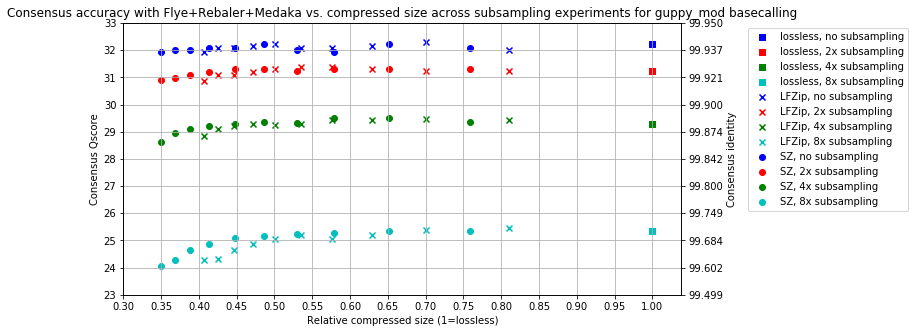

In [57]:
# medaka assembly across subsampling (guppy_mod)
marker = {'LFZip': 'x', 'SZ': 'o'}
compressed_sizes = {'LFZip': LFZip_sizes_sum/lossless_sizes_sum, 'SZ': SZ_sizes_sum/lossless_sizes_sum}
legend = []

def phred(x):
    return -10*np.log10((100-x)/100)
    
_,ax_phred = plt.subplots(figsize=(10,5))
ax_percent = ax_phred.twinx()

assembler = 'medaka'
basecaller = 'guppy_mod'
subsampling_legend = ['no subsampling','2x subsampling','4x subsampling', '8x subsampling']
color = ['b','r','g','c']

# scatter plots
for sidx in range(4):
    ax_phred.scatter(1.0,phred(assembly_identity[basecaller][sidx]['lossless'][assembler]),marker='s',color=color[sidx])
    legend.append('lossless, '+subsampling_legend[sidx])
for compressor in ['LFZip','SZ']:
    for sidx in range(4):
        ax_phred.scatter(compressed_sizes[compressor],\
                    phred(assembly_identity[basecaller][sidx][compressor][assembler]),\
                    color=color[sidx], marker=marker[compressor])
        legend.append(compressor+', '+subsampling_legend[sidx])
ax_phred.legend(legend,bbox_to_anchor=(1.11,1), loc="upper left")
yticks = list(range(23,34))
ax_phred.set_yticks(yticks)
percent_ticks = 100-100*np.power(10,-np.array(yticks)/10)
percent_ticks_str = ['{:.3f}'.format(val) for val in percent_ticks]
ax_percent.set_ylim(ax_phred.get_ylim())
ax_percent.set_yticks(ax_phred.get_yticks())
ax_percent.set_yticklabels(percent_ticks_str)
ax_phred.set_xticks(np.arange(0.3,1.05,0.05))
ax_phred.set_xlabel('Relative compressed size (1=lossless)')
ax_phred.set_ylabel('Consensus Qscore')
ax_phred.set_title('Consensus accuracy with Flye+Rebaler+Medaka vs. compressed size across subsampling experiments for guppy_mod basecalling')
ax_percent.set_ylabel('Consensus identity')
ax_phred.grid()
plt.savefig('assembly_subsampling_medaka_guppy_mod.pdf',bbox_inches='tight')

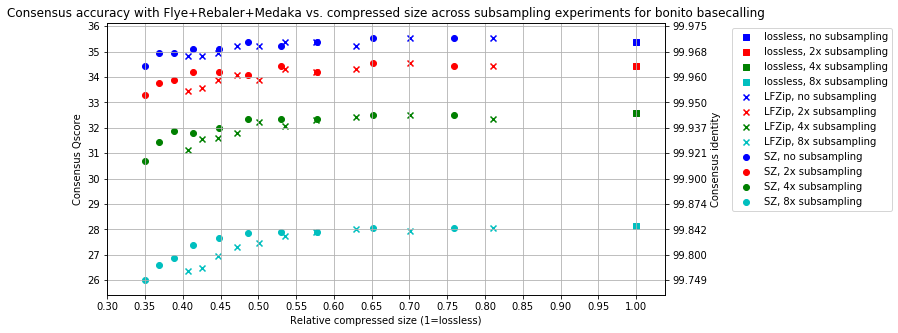

In [59]:
# medaka assembly across subsampling (bonito)
marker = {'LFZip': 'x', 'SZ': 'o'}
compressed_sizes = {'LFZip': LFZip_sizes_sum/lossless_sizes_sum, 'SZ': SZ_sizes_sum/lossless_sizes_sum}
legend = []

def phred(x):
    return -10*np.log10((100-x)/100)
    
_,ax_phred = plt.subplots(figsize=(10,5))
ax_percent = ax_phred.twinx()

assembler = 'medaka'
basecaller = 'bonito'
subsampling_legend = ['no subsampling','2x subsampling','4x subsampling', '8x subsampling']
color = ['b','r','g','c']

# scatter plots
for sidx in range(4):
    ax_phred.scatter(1.0,phred(assembly_identity[basecaller][sidx]['lossless'][assembler]),marker='s',color=color[sidx])
    legend.append('lossless, '+subsampling_legend[sidx])
for compressor in ['LFZip','SZ']:
    for sidx in range(4):
        ax_phred.scatter(compressed_sizes[compressor],\
                    phred(assembly_identity[basecaller][sidx][compressor][assembler]),\
                    color=color[sidx], marker=marker[compressor])
        legend.append(compressor+', '+subsampling_legend[sidx])
ax_phred.legend(legend,bbox_to_anchor=(1.11,1), loc="upper left")
yticks = list(range(26,37))
ax_phred.set_yticks(yticks)
percent_ticks = 100-100*np.power(10,-np.array(yticks)/10)
percent_ticks_str = ['{:.3f}'.format(val) for val in percent_ticks]
ax_percent.set_ylim(ax_phred.get_ylim())
ax_percent.set_yticks(ax_phred.get_yticks())
ax_percent.set_yticklabels(percent_ticks_str)
ax_phred.set_xticks(np.arange(0.3,1.05,0.05))
ax_phred.set_xlabel('Relative compressed size (1=lossless)')
ax_phred.set_ylabel('Consensus Qscore')
ax_phred.set_title('Consensus accuracy with Flye+Rebaler+Medaka vs. compressed size across subsampling experiments for bonito basecalling')
ax_percent.set_ylabel('Consensus identity')
ax_phred.grid()
plt.savefig('assembly_subsampling_medaka_bonito.pdf',bbox_inches='tight')

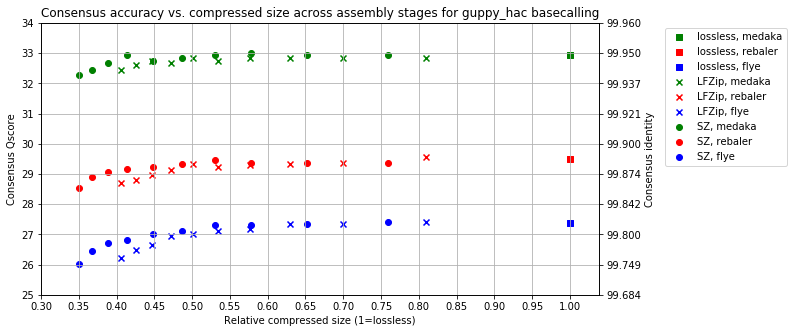

In [60]:
assemblers = ['medaka','rebaler','flye',]
color = {'flye': 'b', 'rebaler': 'r', 'medaka': 'g'}
marker = {'LFZip': 'x', 'SZ': 'o'}
basecaller = 'guppy_hac'
sidx = 0 # no subsampling
compressed_sizes = {'LFZip': LFZip_sizes_sum/lossless_sizes_sum, 'SZ': SZ_sizes_sum/lossless_sizes_sum}
legend = []

def phred(x):
    return -10*np.log10((100-x)/100)
    
_,ax_phred = plt.subplots(figsize=(10,5))
ax_percent = ax_phred.twinx()

# scatter plots
for assembler in assemblers:
    ax_phred.scatter(1.0,phred(assembly_identity[basecaller][sidx]['lossless'][assembler]),marker='s',color=color[assembler])
    legend.append('lossless, '+assembler)
for compressor in ['LFZip','SZ']:
    for assembler in assemblers:
        ax_phred.scatter(compressed_sizes[compressor],\
                    phred(assembly_identity[basecaller][sidx][compressor][assembler]),\
                    color=color[assembler], marker=marker[compressor])
        legend.append(compressor+', '+assembler)
ax_phred.legend(legend,bbox_to_anchor=(1.11,1), loc="upper left")
yticks = list(range(25,35))
ax_phred.set_yticks(yticks)
percent_ticks = 100-100*np.power(10,-np.array(yticks)/10)
percent_ticks_str = ['{:.3f}'.format(val) for val in percent_ticks]
ax_percent.set_ylim(ax_phred.get_ylim())
ax_percent.set_yticks(ax_phred.get_yticks())
ax_percent.set_yticklabels(percent_ticks_str)
ax_phred.set_xticks(np.arange(0.3,1.05,0.05))
ax_phred.set_xlabel('Relative compressed size (1=lossless)')
ax_phred.set_ylabel('Consensus Qscore')
ax_percent.set_ylabel('Consensus identity')
ax_phred.set_title('Consensus accuracy vs. compressed size across assembly stages for guppy_hac basecalling')
ax_phred.grid()
plt.savefig('assembly_guppy_hac_assemblers.pdf',bbox_inches='tight')

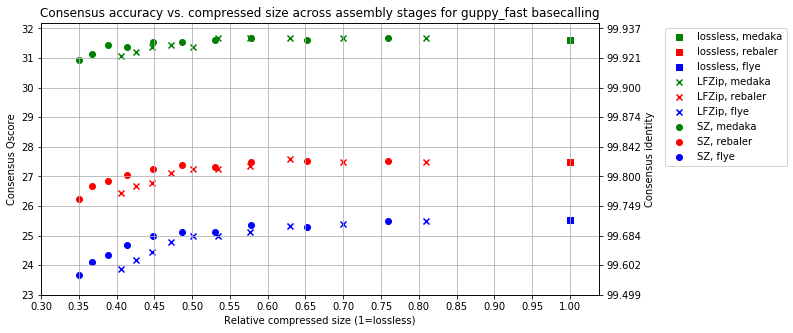

In [61]:
assemblers = ['medaka','rebaler','flye',]
color = {'flye': 'b', 'rebaler': 'r', 'medaka': 'g'}
marker = {'LFZip': 'x', 'SZ': 'o'}
basecaller = 'guppy_fast'
sidx = 0 # no subsampling
compressed_sizes = {'LFZip': LFZip_sizes_sum/lossless_sizes_sum, 'SZ': SZ_sizes_sum/lossless_sizes_sum}
legend = []

def phred(x):
    return -10*np.log10((100-x)/100)
    
_,ax_phred = plt.subplots(figsize=(10,5))
ax_percent = ax_phred.twinx()

# scatter plots
for assembler in assemblers:
    ax_phred.scatter(1.0,phred(assembly_identity[basecaller][sidx]['lossless'][assembler]),marker='s',color=color[assembler])
    legend.append('lossless, '+assembler)
for compressor in ['LFZip','SZ']:
    for assembler in assemblers:
        ax_phred.scatter(compressed_sizes[compressor],\
                    phred(assembly_identity[basecaller][sidx][compressor][assembler]),\
                    color=color[assembler], marker=marker[compressor])
        legend.append(compressor+', '+assembler)
ax_phred.legend(legend,bbox_to_anchor=(1.11,1), loc="upper left")
yticks = list(range(23,33))
ax_phred.set_yticks(yticks)
percent_ticks = 100-100*np.power(10,-np.array(yticks)/10)
percent_ticks_str = ['{:.3f}'.format(val) for val in percent_ticks]
ax_percent.set_ylim(ax_phred.get_ylim())
ax_percent.set_yticks(ax_phred.get_yticks())
ax_percent.set_yticklabels(percent_ticks_str)
ax_phred.set_xticks(np.arange(0.3,1.05,0.05))
ax_phred.set_xlabel('Relative compressed size (1=lossless)')
ax_phred.set_ylabel('Consensus Qscore')
ax_percent.set_ylabel('Consensus identity')
ax_phred.set_title('Consensus accuracy vs. compressed size across assembly stages for guppy_fast basecalling')
ax_phred.grid()
plt.savefig('assembly_guppy_fast_assemblers.pdf',bbox_inches='tight')

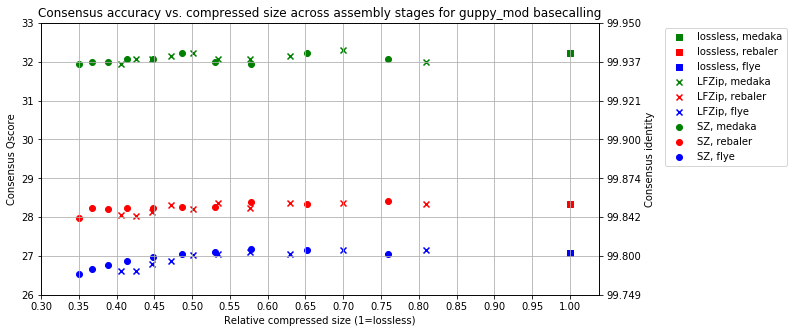

In [62]:
assemblers = ['medaka','rebaler','flye',]
color = {'flye': 'b', 'rebaler': 'r', 'medaka': 'g'}
marker = {'LFZip': 'x', 'SZ': 'o'}
basecaller = 'guppy_mod'
sidx = 0 # no subsampling
compressed_sizes = {'LFZip': LFZip_sizes_sum/lossless_sizes_sum, 'SZ': SZ_sizes_sum/lossless_sizes_sum}
legend = []

def phred(x):
    return -10*np.log10((100-x)/100)
    
_,ax_phred = plt.subplots(figsize=(10,5))
ax_percent = ax_phred.twinx()

# scatter plots
for assembler in assemblers:
    ax_phred.scatter(1.0,phred(assembly_identity[basecaller][sidx]['lossless'][assembler]),marker='s',color=color[assembler])
    legend.append('lossless, '+assembler)
for compressor in ['LFZip','SZ']:
    for assembler in assemblers:
        ax_phred.scatter(compressed_sizes[compressor],\
                    phred(assembly_identity[basecaller][sidx][compressor][assembler]),\
                    color=color[assembler], marker=marker[compressor])
        legend.append(compressor+', '+assembler)
ax_phred.legend(legend,bbox_to_anchor=(1.11,1), loc="upper left")
yticks = list(range(26,34))
ax_phred.set_yticks(yticks)
percent_ticks = 100-100*np.power(10,-np.array(yticks)/10)
percent_ticks_str = ['{:.3f}'.format(val) for val in percent_ticks]
ax_percent.set_ylim(ax_phred.get_ylim())
ax_percent.set_yticks(ax_phred.get_yticks())
ax_percent.set_yticklabels(percent_ticks_str)
ax_phred.set_xticks(np.arange(0.3,1.05,0.05))
ax_phred.set_xlabel('Relative compressed size (1=lossless)')
ax_phred.set_ylabel('Consensus Qscore')
ax_percent.set_ylabel('Consensus identity')
ax_phred.set_title('Consensus accuracy vs. compressed size across assembly stages for guppy_mod basecalling')
ax_phred.grid()
plt.savefig('assembly_guppy_mod_assemblers.pdf',bbox_inches='tight')

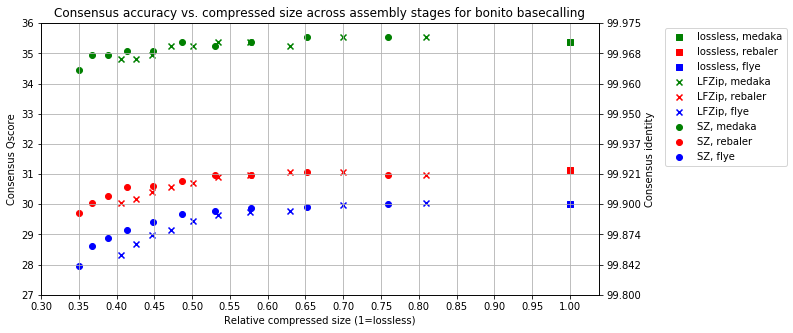

In [64]:
assemblers = ['medaka','rebaler','flye',]
color = {'flye': 'b', 'rebaler': 'r', 'medaka': 'g'}
marker = {'LFZip': 'x', 'SZ': 'o'}
basecaller = 'bonito'
sidx = 0 # no subsampling
compressed_sizes = {'LFZip': LFZip_sizes_sum/lossless_sizes_sum, 'SZ': SZ_sizes_sum/lossless_sizes_sum}
legend = []

def phred(x):
    return -10*np.log10((100-x)/100)
    
_,ax_phred = plt.subplots(figsize=(10,5))
ax_percent = ax_phred.twinx()

# scatter plots
for assembler in assemblers:
    ax_phred.scatter(1.0,phred(assembly_identity[basecaller][sidx]['lossless'][assembler]),marker='s',color=color[assembler])
    legend.append('lossless, '+assembler)
for compressor in ['LFZip','SZ']:
    for assembler in assemblers:
        ax_phred.scatter(compressed_sizes[compressor],\
                    phred(assembly_identity[basecaller][sidx][compressor][assembler]),\
                    color=color[assembler], marker=marker[compressor])
        legend.append(compressor+', '+assembler)
ax_phred.legend(legend,bbox_to_anchor=(1.11,1), loc="upper left")
yticks = list(range(27,37))
ax_phred.set_yticks(yticks)
percent_ticks = 100-100*np.power(10,-np.array(yticks)/10)
percent_ticks_str = ['{:.3f}'.format(val) for val in percent_ticks]
ax_percent.set_ylim(ax_phred.get_ylim())
ax_percent.set_yticks(ax_phred.get_yticks())
ax_percent.set_yticklabels(percent_ticks_str)
ax_phred.set_xticks(np.arange(0.3,1.05,0.05))
ax_phred.set_xlabel('Relative compressed size (1=lossless)')
ax_phred.set_ylabel('Consensus Qscore')
ax_percent.set_ylabel('Consensus identity')
ax_phred.set_title('Consensus accuracy vs. compressed size across assembly stages for bonito basecalling')
ax_phred.grid()
plt.savefig('assembly_bonito_assemblers.pdf',bbox_inches='tight')